[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


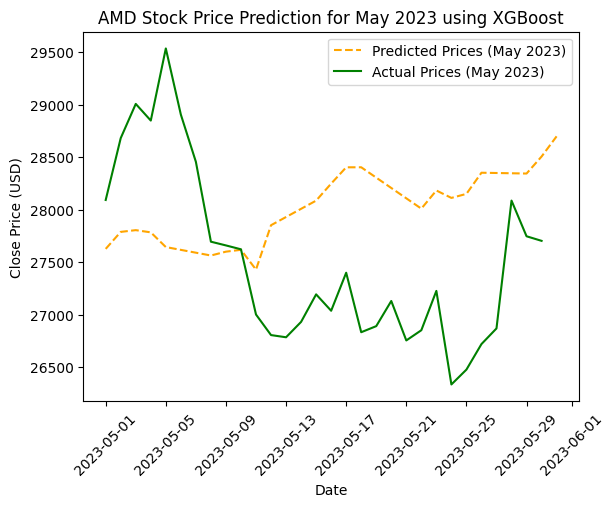

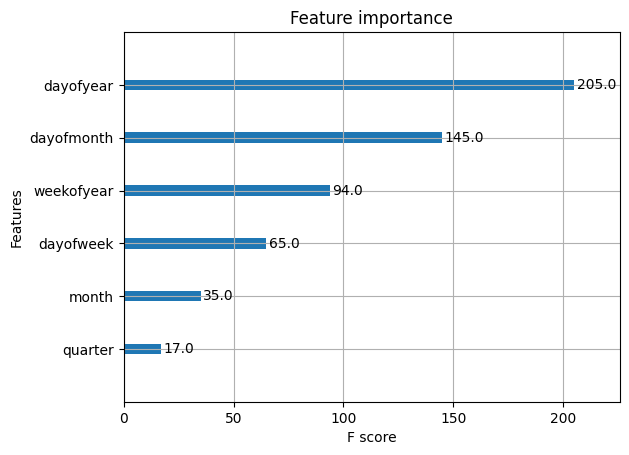


Predicted vs. Actual Prices for May 2023:
            Predicted Prices  Actual Prices
2023-05-01      27625.779297   28091.568359
2023-05-02      27787.666016   28680.537109
2023-05-03      27804.183594   29006.308594
2023-05-04      27783.222656   28847.710938
2023-05-05      27643.251953   29534.384766
2023-05-06               NaN   28904.623047
2023-05-07               NaN   28454.978516
2023-05-08      27562.646484   27694.273438
2023-05-09      27599.343750   27658.775391
2023-05-10      27617.058594   27621.755859
2023-05-11      27428.255859   27000.789062
2023-05-12      27851.248047   26804.990234
2023-05-13               NaN   26784.078125
2023-05-14               NaN   26930.638672
2023-05-15      28085.333984   27192.693359
2023-05-16      28247.417969   27036.650391
2023-05-17      28402.539062   27398.802734
2023-05-18      28402.914062   26832.208984
2023-05-19      28304.203125   26890.128906
2023-05-20               NaN   27129.585938
2023-05-21               NaN   26

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Function to create a variety of time-based features from a time series DataFrame
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


# Download AMD stock data for training (up to end of April 2023)
df_train = yf.download('BTC-USD', start='2023-01-01', end='2023-04-30')
df_train['Weighted_Price'] = df_train['Close']

# Create training features and labels
X_train, y_train = create_features(df_train, label='Weighted_Price')

# Initialize the XGBoost model with specified parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    min_child_weight=10,
    booster='gbtree',
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=100
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

# Generate dates for May 2023 (without downloading the actual data yet)
may_dates = pd.date_range(start='2023-05-01', end='2023-05-31', freq='B')  # Business days in May
df_may = pd.DataFrame(index=may_dates)

# Create features for the synthetic May 2023 dates
X_may = create_features(df_may)

# Make predictions for May 2023
df_may['Weighted_Price_Prediction'] = model.predict(X_may)

# Download actual AMD stock data for May 2023 after prediction for comparison
df_actual_may = yf.download('BTC-USD', start='2023-05-01', end='2023-05-31')

# Plot the historical prices, predictions, and actual May 2023 prices
# plt.figure(figsize=(14, 7))

# Plot actual prices up to April 2023
# plt.plot(df_train.index, df_train['Weighted_Price'], label='Actual Prices (Up to April)', color='blue')

# Plot predictions for May 2023
plt.plot(df_may.index, df_may['Weighted_Price_Prediction'], color='orange', linestyle='dashed',
         label='Predicted Prices (May 2023)')

# Plot actual May 2023 prices
plt.plot(df_actual_may.index, df_actual_may['Close'], color='green', label='Actual Prices (May 2023)')

# Customize the plot
plt.title('AMD Stock Price Prediction for May 2023 using XGBoost')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Show feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()

# Print predicted and actual prices for May 2023
comparison_df = pd.DataFrame({
    'Predicted Prices': df_may['Weighted_Price_Prediction'],
    'Actual Prices': df_actual_may['Close']
})
print("\nPredicted vs. Actual Prices for May 2023:")
print(comparison_df)